In [1]:
import numpy as np
import cv2
from openvino.inference_engine import IECore
import matplotlib.pyplot as plt
import time

## Read Image

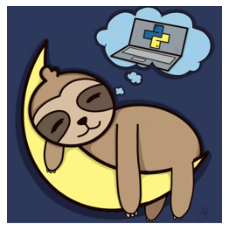

In [2]:
file_path = 'data/images/logo.jpg'
image = cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Prepare Model

In [3]:
def PrepareNetWork(onnx_model,device):
    ie = IECore()
    ############## Slight Change #############
    net = ie.read_network(model = onnx_model)
    #########################################
    
    ####################### Very Important #############################################
    # Check to make sure that the plugin has support for all layers in the model
    supported_layers = ie.query_network(net,device_name = device)
    unsupported_layers = [layer for layer in supported_layers.values() if layer!= device]
    if len(unsupported_layers)>0:
        raise Exception(f"Number of unsupported layers {len(unsupported_layers)}")
    ####################################################################################
    

    exec_net = ie.load_network(network=net, device_name = device)

    # Store name of input and output blobs
    input_blob = next(iter(net.input_info))
    output_blob = next(iter(net.outputs))

    # Extract Dimension (n:batch, c:color channel,h: height, w: width )
    n, c ,h ,w = net.input_info[input_blob].input_data.shape
    print('Extract Model Input Dimension:',n,c,h,w)
    
    return (input_blob,output_blob), exec_net, (n,c,h,w)

def PrepareInputImage(input_path,n,c,h,w):
    
    # height width channels
    image = cv2.imread(input_path)
    
    # Resize
    in_frame = cv2.resize(image,(w,h))
    in_frame = in_frame.transpose((2,0,1)) # Moving color channels to head
    in_frame = in_frame.reshape((n,c,h,w))
    return image, in_frame

def MakePrediction(execution_network, input_blob, inference_frame):
    st_time = time.time()
    # Run Inference
    result = execution_network.infer(inputs = {input_blob:inference_frame})
    
    ed_time = time.time()
    
    
    time_sp = ed_time-st_time
    FPS = np.round((1/time_sp),4)
    print(f"FPS: {FPS}\n")
    
    return FPS,result

In [4]:
# Model Path
onnx_model = 'intel_models/StyleGAN.onnx'

# Device
device = 'CPU' # Options include CPU, GPU, MYRIAD, [HDDL or HETERO] I am not familiar with the last two

# Prepare Network
inputs_outputs, execution_network, dimensions = PrepareNetWork(onnx_model,device)

# Extract Required Input dimension
n,c,h,w = dimensions

# Extract input and output names
input_blob, output_blob = inputs_outputs

# Print Networf Information
print(f"Input_name: {input_blob:>6}\nOutput_name: {output_blob:>5}")
print(f"OpenVINO Engine: {execution_network}")

Extract Model Input Dimension: 1 3 224 224
Input_name: input1
Output_name: output1
OpenVINO Engine: <openvino.inference_engine.ie_api.ExecutableNetwork object at 0x000001B87B462450>


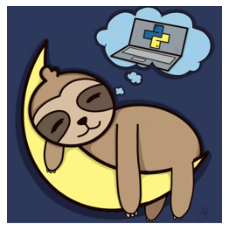

In [5]:
original_image, inference_frame = PrepareInputImage(file_path,n,c,h,w)
plt.imshow(cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

FPS: 23.2578



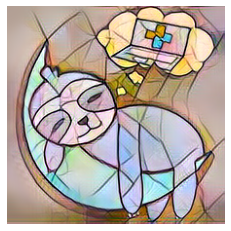

In [6]:
FPS, result = MakePrediction(execution_network,input_blob,inference_frame)

styled_image = result[output_blob]
styled_image = styled_image[0]
styled_image = styled_image.transpose((1,2,0))
styled_image = np.clip(styled_image, 0, 255)

plt.imshow(styled_image/255)
plt.axis('off')
plt.show()